<table style='border: none' align='left'>
   <tr style='border: none'>
      <th style='border: none'><font face='verdana' size='5' color='black'><b>Use XGBoost to classify tumors with IBM Watson Machine Learning</b></th>
      <th style='border: none'><img src='https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true' alt='Watson Machine Learning icon' height='40' width='40'></th>
   </tr>
   <tr style='border: none'>
       <th style='border: none'><img src='https://raw.githubusercontent.com/pmservice/wml-sample-notebooks/master/images/cancer_banner-06.png' alt='Icon' width='700'> </th>
   </tr>
</table>

This notebook demonstates how to obtain data from the IBM Watson Studio Community, create a predictive model, and score the model.
Some familiarity with Python is helpful. This notebook is compatible with Python 3.6 and uses XGBoost and scikit-learn.

You will use a publicly available data set, the Breast Cancer Wisconsin (Diagnostic) data set, to train an XGBoost Model to classify breast cancer tumors (as benign or malign.) There are 569 data points in the Breast Cancer Wisconsin (Diagnostic) data set, and each data point has predictors such as radius, texture, perimeter, and area. XGBoost stands for “E**x**treme **G**radient **Boost**ing”.

The XGBoost classifier makes its predictions based on the majority vote from a collection of models which are a set of classification trees. It uses the combination of weak learners to create a single strong learner. It is a sequential training process where new learners focus on the misclassified examples of previous learners.


## Learning goals

You will learn how to:

-  Load a CSV file into a pandas dataframe
-  Explore data
-  Prepare data for training and evaluation
-  Create an XGBoost machine learning model
-  Train and evaluate the model
-  Use cross-validation to optimize model's hyperparameters
-  Persist the model in the Watson Machine Learning repository
-  Deploy the model for online scoring
-  Score test data


## Contents

This notebook contains the following parts:

1.	[Set up the environment](#setup)
2.	[Load and explore the data](#load)
3.	[Create an XGBoost model](#model)
4.	[Persist the model](#persistence)
5.	[Deploy and score the model in the WML repository](#scoring)
6.	[Summary and next steps](#summary)

<a id='setup'></a>
## 1. Set up the environment

Before running the code in this notebook, please make sure you have the following requirements:

-  A <a href="https://cloud.ibm.com/catalog/services/machine-learning" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create an instance can be found <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>)

-  Local python environment configurations:
  + Python 3.6
  + xgboost
  + watson-machine-learning-client
  + pixiedust
  + matplotlib
  + seaborn

- Download **Breast Cancer Wisconsin (Diagnostic) Data Set** dataset from the Watson Studio <a href="https://dataplatform.ibm.com/community?context=analytics" target="_blank" rel="noopener no referrer">Community</a>.

**Note:** We provide the code to download the data set in [step 2](#load).

<a id='load'></a>
## 2. Load and explore the data

In this section, you will load the data into a pandas dataframe and perform an exploratory data analysis (EDA).

To load the data into a pandas dataframe, use `wget` to download the data first and `pandas` to read the data.

**Example**: First, you need to install the required packages. You can do this by running the following code. Run it only once.<BR><BR>

In [ ]:
!pip install --upgrade wget

In [2]:
# Get the data.
import wget
import os

wisconsin_data = 'BreastCancerwisconsin_data.csv' 

if not os.path.isfile(wisconsin_data):
    link_to_data = 'https://dataplatform.cloud.ibm.com/data/exchange-api/v1/entries/c173693bf48aeb22e41bbe2b41d79c1f/data?accessKey=5f41fd5a963ddd59ba6c746a21b85361'
    wisconsin_data = wget.download(link_to_data)

print(wisconsin_data)

BreastCancerWisconsinDataSet (3).csv


The csv file **BreastCancerWisconsinDataSet.csv** is downloaded. Run the code in the following cells to load the file as a pandas dataframe.

**Note:** Update the packages to ensure you have the latest version.

`pixiedust` is an open-source Python helper library that works as an add-on to Jupyter notebooks to improve the user experience of working with data.  
`pixiedust` documentation/code can be found <a href="https://github.com/pixiedust/pixiedust" target="_blank" rel="noopener no referrer">here</a>.  

In [ ]:
!pip install --upgrade pixiedust

In [4]:
import pandas as pd

df = pd.read_csv(wisconsin_data).iloc[:, 1:]

Import ``pixiedust``.

In [5]:
import pixiedust

Pixiedust database opened successfully


You can run the following method if you don't want pixiedust collecting user statistics.

In [6]:
pixiedust.optOut()

Pixiedust will not collect anonymous install statistics.


In this notebook, ``pixiedust`` will only be used as a dataframe viewer. However, ``pixiedust`` can also be used as a data visualization tool. You can find the details of the visualization functionality of ``pixiedust`` <a href="https://pixiedust.github.io/pixiedust/displayapi.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
display(df)

Run the code in the next cell to view the predictor names and data types.

You can see that the data set has 569 data points and 31 predictors.

In [8]:
# Information about the data set, predictor names, and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave points_se          569 n

In [9]:
# Information about values in the numerical columns.
df.describe()

radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       symmetry_mean  fractal_dimension_mean  ...  radius_worst  \
count     569.000000              569.000000  ...    569.000000   
mean        0.181162                0.062798  ...     16.269190   
std         0.027414                0.007060  ...      4.833242   
min         0.106000                0.049960  ...      7.930000   
25%         0.161900                0.057700  ...     13.010000   
50%         0.179200                0.061540  ...     14.970000   
75%         0.195700                0.066120  ...     18.790000   
max         0.304000                0.097440  ...     36.040000   

       texture_worst  perimeter_worst   area_worst  smoothness_worst  \
count     569.000000       569.000000   569.000000        569.000000   
mean       25.677223       107.261213   880.583128          0.132369   
std         6.146258        33.602542   569.356993          0.022832   
min        12.020000        50.410000   185.200000          0.071170   
25%        21.080000        84.110000   515.300000          0.116600   
50%        25.410000        97.660000   686.500000          0.131300   
75%        29.720000       125.400000  1084.000000          0.146000   
max        49.540000       251.200000  4254.000000          0.222600   

       compactness_worst  concavity_worst  concave points_worst  \
count         569.000000       569.000000            569.000000   
mean            0.254265         0.272188              0.114606   
std             0.157336         0.208624              0.065732   
min             0.027290         0.000000              0.000000   
25%             0.147200         0.114500              0.064930   
50%             0.211900         0.226700              0.099930   
75%             0.339100         0.382900              0.161400   
max             1.058000         1.252000              0.291000   

       symmetry_worst  fractal_dimension_worst  
count      569.000000               569.000000  
mean         0.290076                 0.083946  
std          0.061867                 0.018061  
min          0.156500                 0.055040  
25%          0.250400                 0.071460  
50%          0.282200                 0.080040  
75%          0.317900                 0.092080  
max          0.663800                 0.207500  

[8 rows x 30 columns]

You can see the distribution of the target values/labels by running the following code.

In [10]:
# Distribution of target values/labels.
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [11]:
# Check for NANs.
df.isnull().sum().sum()

0

The data set has no missing values.

In order to make accurate predictions, you need to select the significant predictors by choosing the features that most affect the output, *diagnosis*.

In [12]:
# pairwise correlation of numerical columns
df.corr()

radius_mean  texture_mean  perimeter_mean  area_mean  \
radius_mean                 1.000000      0.323782        0.997855   0.987357   
texture_mean                0.323782      1.000000        0.329533   0.321086   
perimeter_mean              0.997855      0.329533        1.000000   0.986507   
area_mean                   0.987357      0.321086        0.986507   1.000000   
smoothness_mean             0.170581     -0.023389        0.207278   0.177028   
compactness_mean            0.506124      0.236702        0.556936   0.498502   
concavity_mean              0.676764      0.302418        0.716136   0.685983   
concave points_mean         0.822529      0.293464        0.850977   0.823269   
symmetry_mean               0.147741      0.071401        0.183027   0.151293   
fractal_dimension_mean     -0.311631     -0.076437       -0.261477  -0.283110   
radius_se                   0.679090      0.275869        0.691765   0.732562   
texture_se                 -0.097317      0.386358       -0.086761  -0.066280   
perimeter_se                0.674172      0.281673        0.693135   0.726628   
area_se                     0.735864      0.259845        0.744983   0.800086   
smoothness_se              -0.222600      0.006614       -0.202694  -0.166777   
compactness_se              0.206000      0.191975        0.250744   0.212583   
concavity_se                0.194204      0.143293        0.228082   0.207660   
concave points_se           0.376169      0.163851        0.407217   0.372320   
symmetry_se                -0.104321      0.009127       -0.081629  -0.072497   
fractal_dimension_se       -0.042641      0.054458       -0.005523  -0.019887   
radius_worst                0.969539      0.352573        0.969476   0.962746   
texture_worst               0.297008      0.912045        0.303038   0.287489   
perimeter_worst             0.965137      0.358040        0.970387   0.959120   
area_worst                  0.941082      0.343546        0.941550   0.959213   
smoothness_worst            0.119616      0.077503        0.150549   0.123523   
compactness_worst           0.413463      0.277830        0.455774   0.390410   
concavity_worst             0.526911      0.301025        0.563879   0.512606   
concave points_worst        0.744214      0.295316        0.771241   0.722017   
symmetry_worst              0.163953      0.105008        0.189115   0.143570   
fractal_dimension_worst     0.007066      0.119205        0.051019   0.003738   

                         smoothness_mean  compactness_mean  concavity_mean  \
radius_mean                     0.170581          0.506124        0.676764   
texture_mean                   -0.023389          0.236702        0.302418   
perimeter_mean                  0.207278          0.556936        0.716136   
area_mean                       0.177028          0.498502        0.685983   
smoothness_mean                 1.000000          0.659123        0.521984   
compactness_mean                0.659123          1.000000        0.883121   
concavity_mean                  0.521984          0.883121        1.000000   
concave points_mean             0.553695          0.831135        0.921391   
symmetry_mean                   0.557775          0.602641        0.500667   
fractal_dimension_mean          0.584792          0.565369        0.336783   
radius_se                       0.301467          0.497473        0.631925   
texture_se                      0.068406          0.046205        0.076218   
perimeter_se                    0.296092          0.548905        0.660391   
area_se                         0.246552          0.455653        0.617427   
smoothness_se                   0.332375          0.135299        0.098564   
compactness_se                  0.318943          0.738722        0.670279   
concavity_se                    0.248396          0.570517        0.691270   
concave points_se               0.380676          0.642262        0.683260   
symmetry_se                    

In [ ]:
# Import seaborn and matplotlib for data exploration/visialization.
!pip install --upgrade seaborn

import seaborn as sns
import matplotlib.pyplot as plt

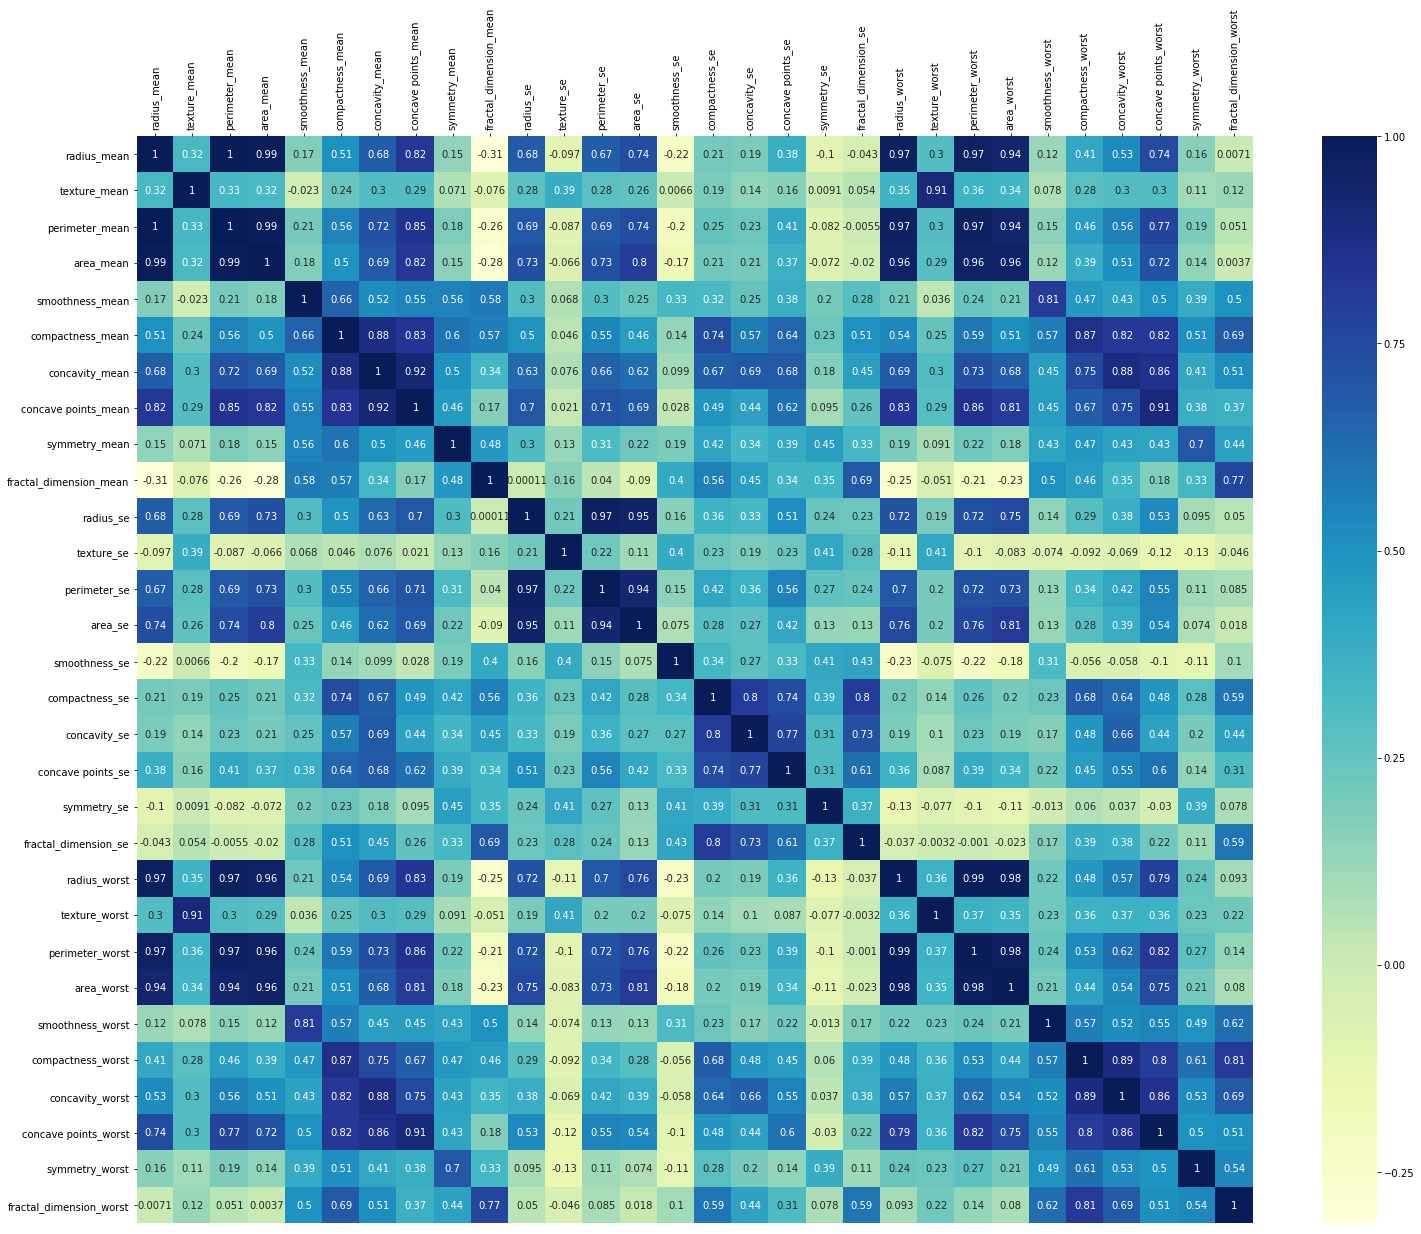

In [14]:
#plot a correlation heatmap
plt.subplots(figsize=(25,20))
hm1 = sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
hm1.set_xticklabels(hm1.get_xticklabels(), rotation=90)
hm1.xaxis.set_ticks_position('top')

This correlation heatmap helps with feature selection because the gradient shows the correlation between the columns of the dataframe. In order to select only the *significant* predictors, you must eliminate features that are highly correlated with each other **(ex: 0.95)**.

With respect to predicting the labels, the most significant predictors can be found by plotting boxplots of the numerical values against the labels. The features with boxplots that show the most variance should be chosen as the predictors for your model.

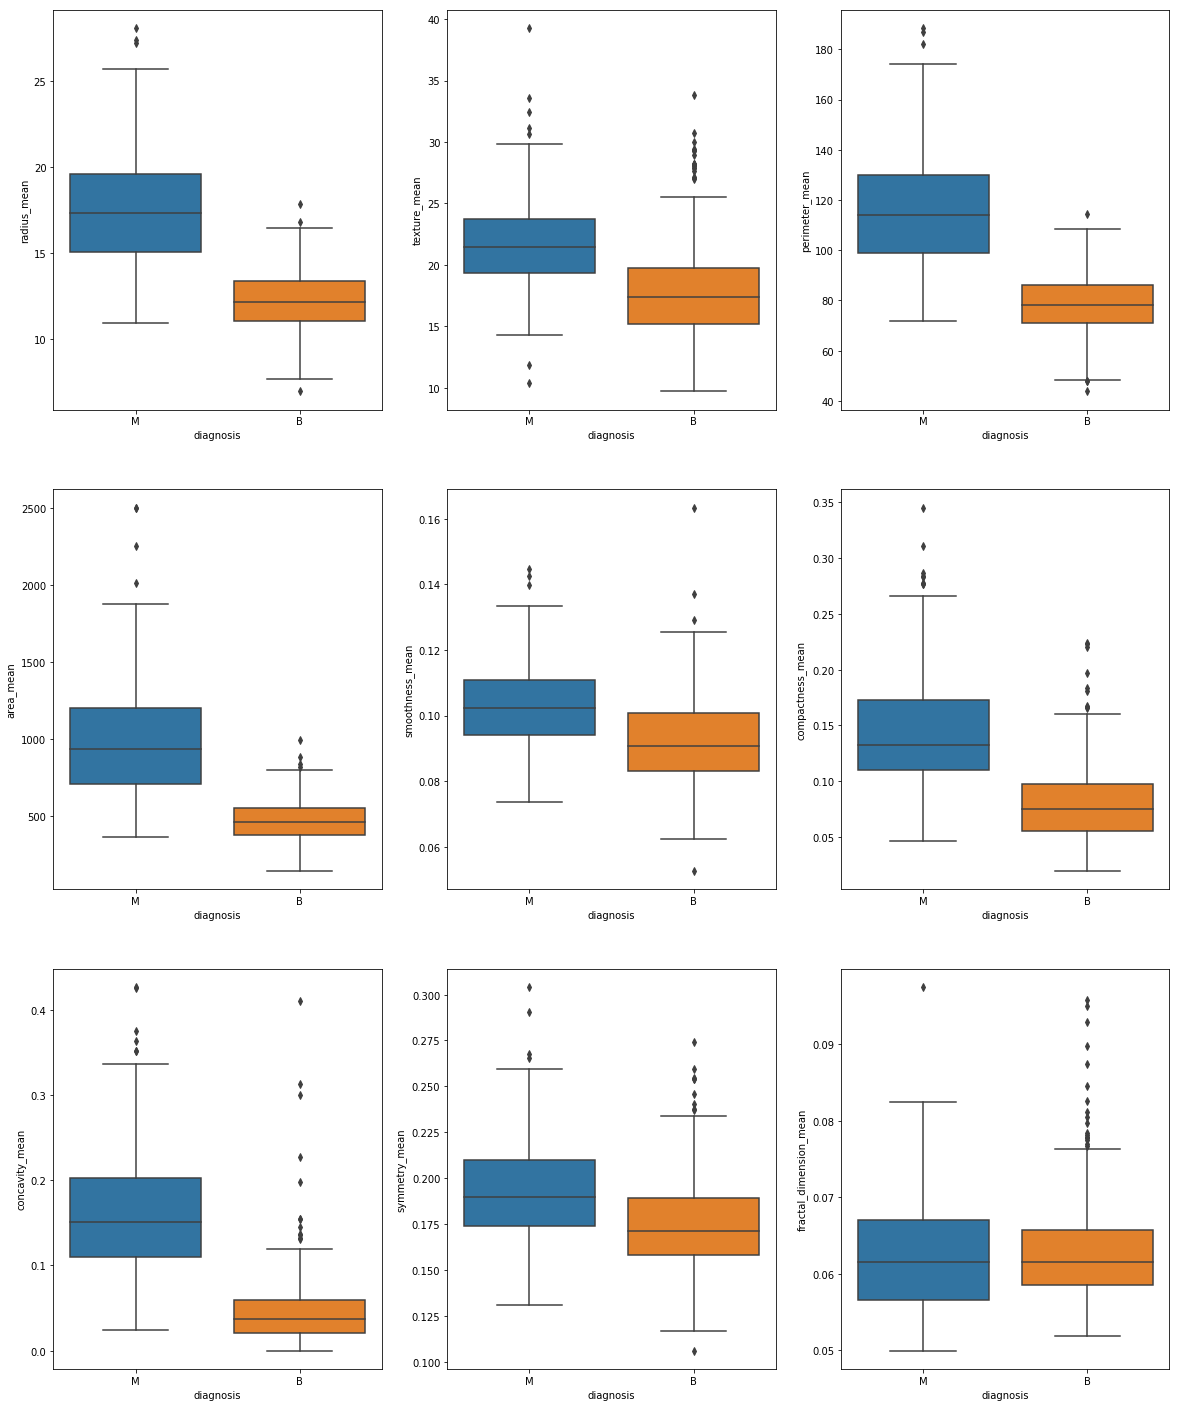

In [15]:
# plot boxplots of numerical columns
cont_list = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'symmetry_mean', 'fractal_dimension_mean']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list)):
    sns.boxplot(x = 'diagnosis', y = cont_list[i], data=df, ax=ax[i])

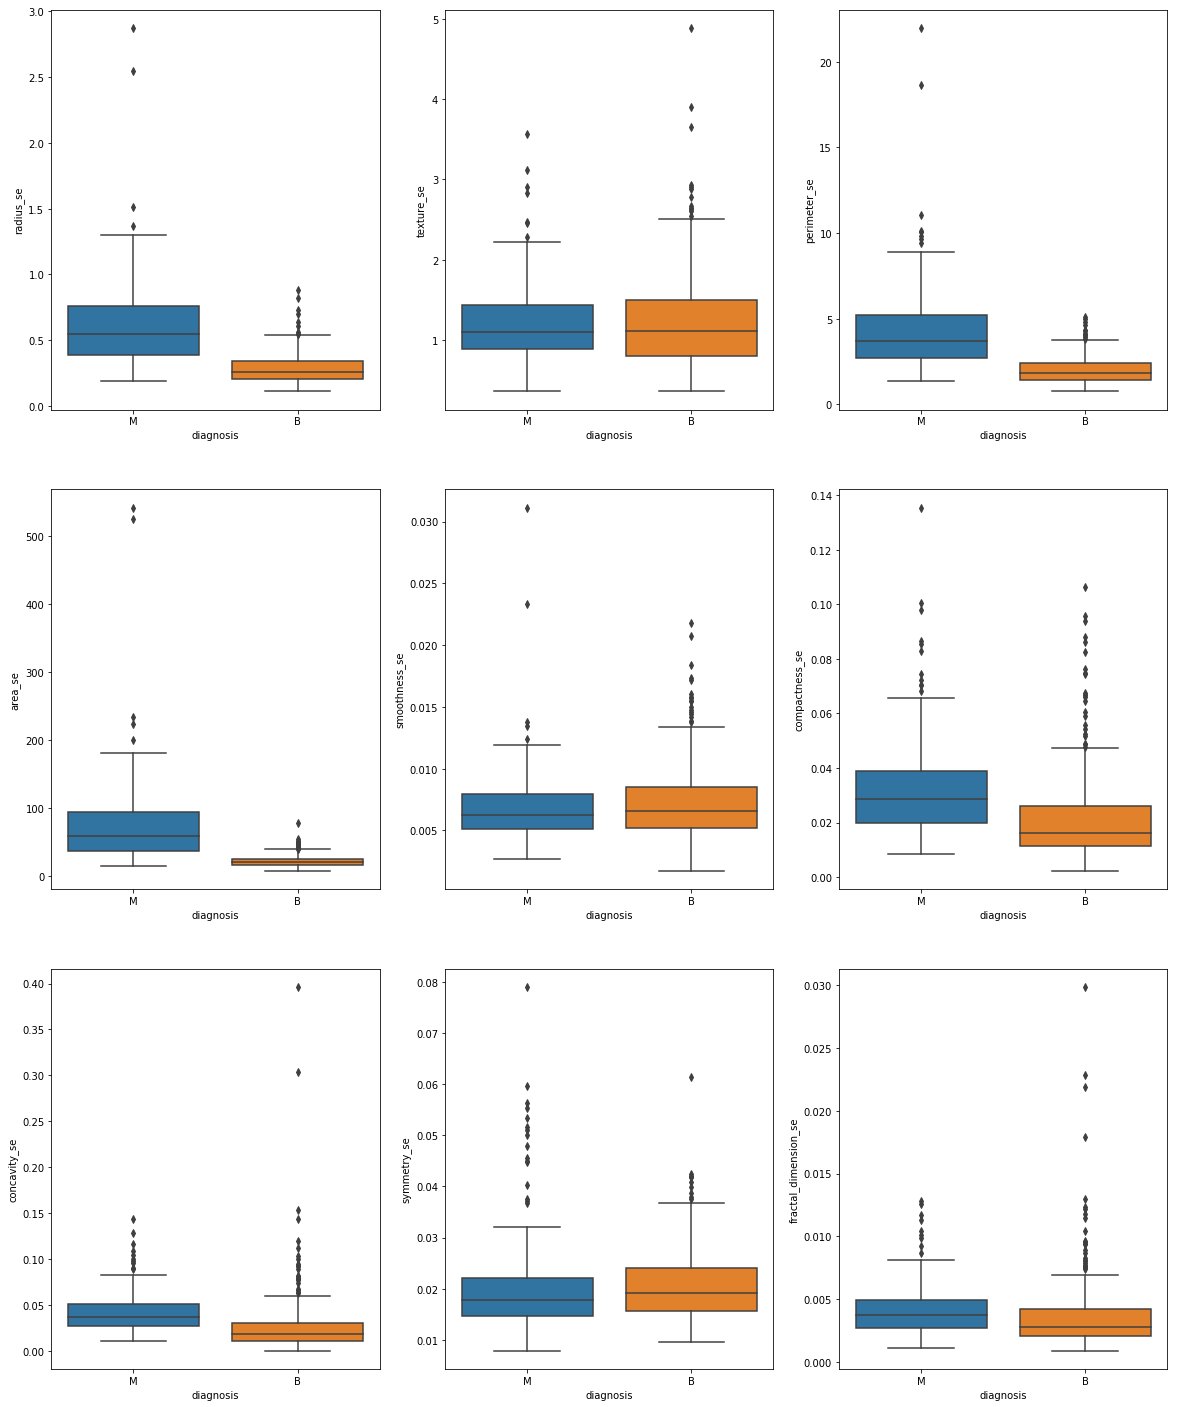

In [16]:
# Plot boxplots of numerical columns.
cont_list2 = ['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list2)):
    sns.boxplot(x = 'diagnosis', y = cont_list2[i], data=df, ax=ax[i])

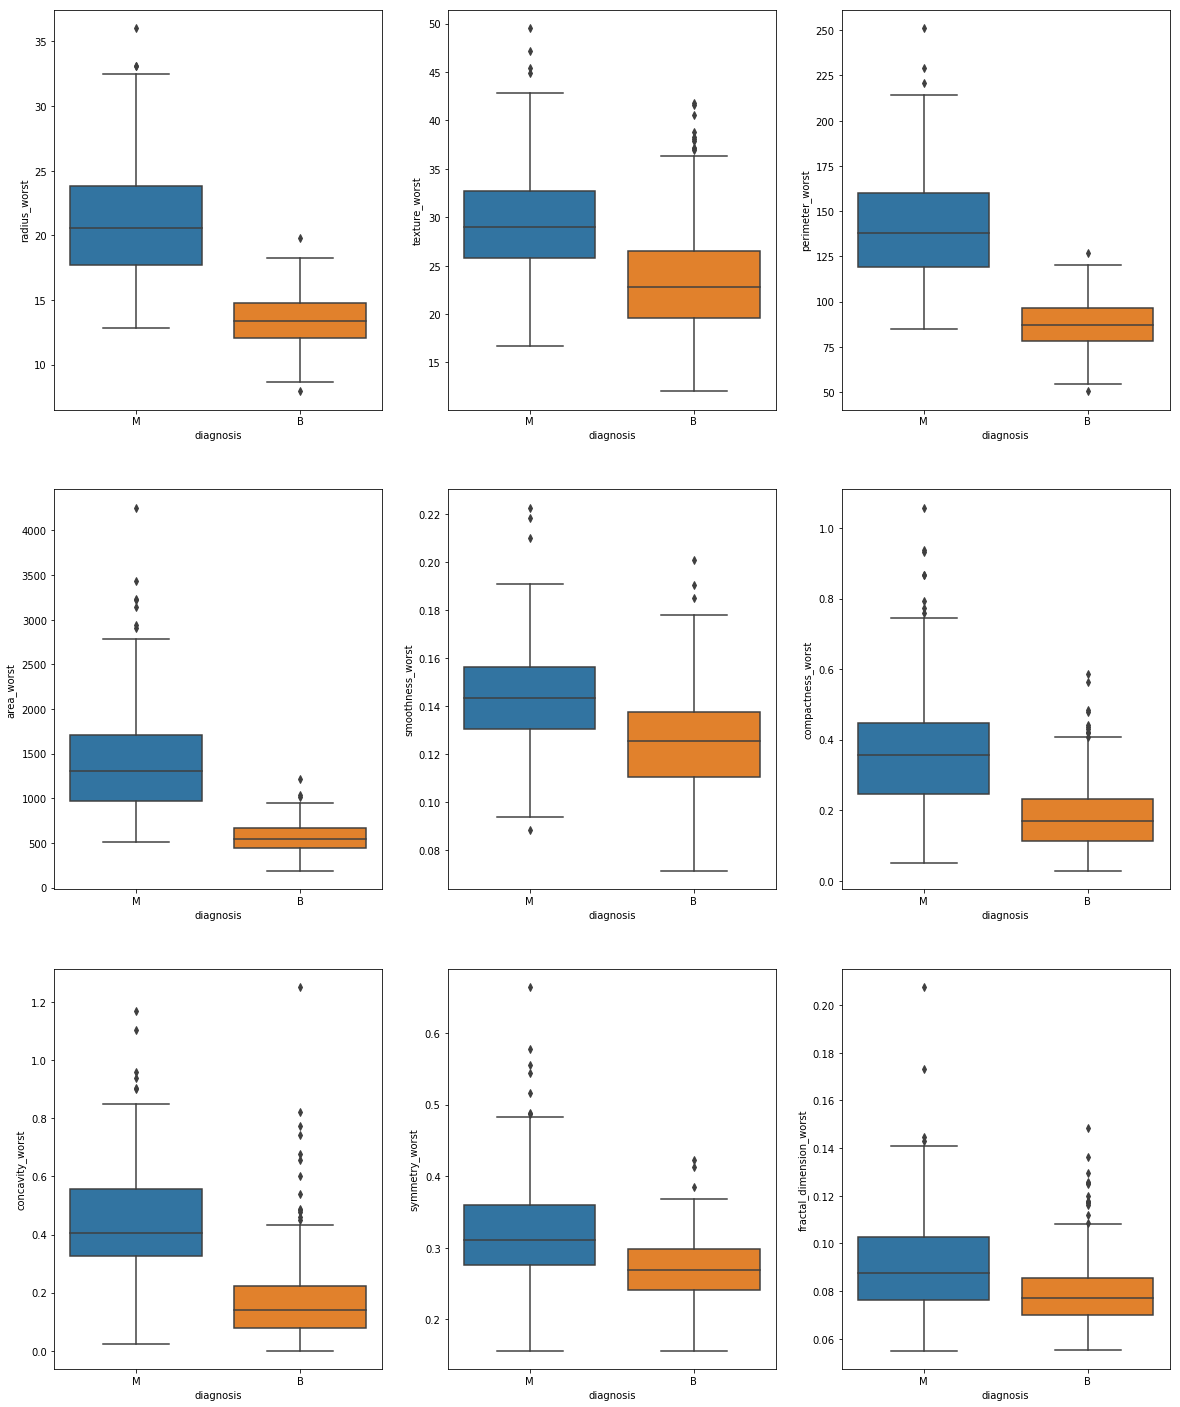

In [17]:
# Plot boxplots of numerical columns.
cont_list3 = ['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'symmetry_worst', 'fractal_dimension_worst']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(len(cont_list3)):
    sns.boxplot(x = 'diagnosis', y = cont_list3[i], data=df, ax=ax[i])

Here are boxplots of the most significant features:

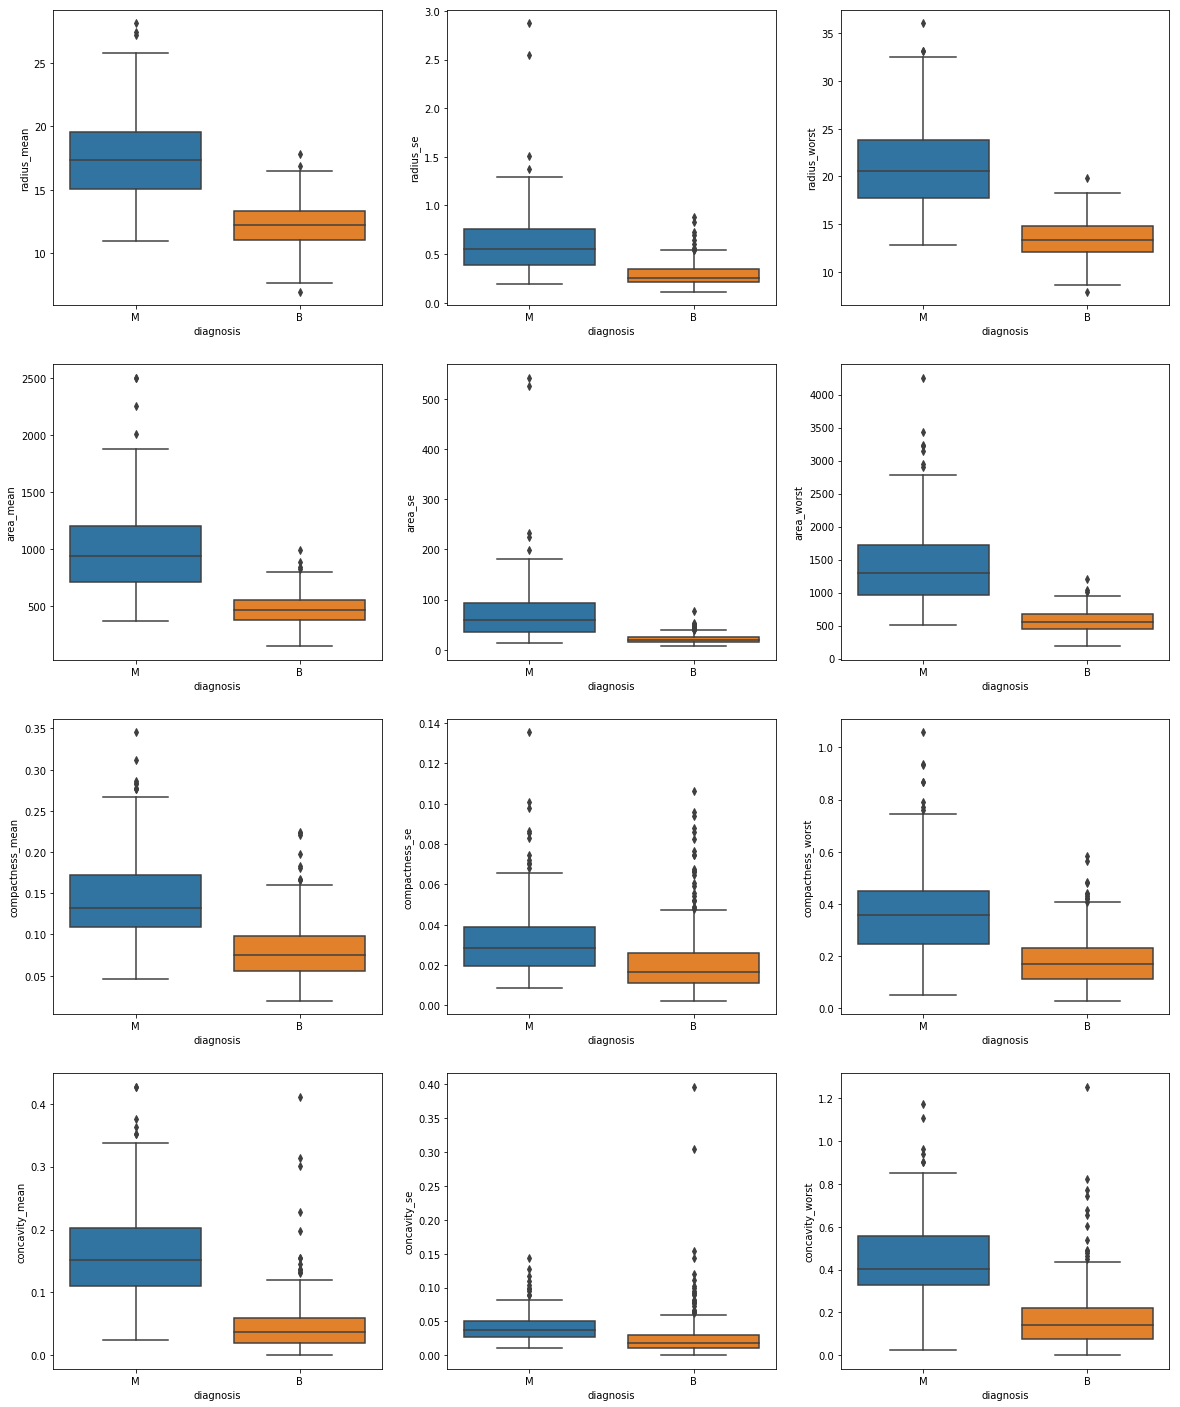

In [18]:
# Compare boxplots of significant numerical columns.
cont_list4 = ['radius_mean', 'radius_se', 'radius_worst', 'area_mean', 'area_se', 'area_worst', 'compactness_mean', 'compactness_se', 'compactness_worst', 'concavity_mean', 'concavity_se', 'concavity_worst']
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize=(20, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12]

for i in range(len(cont_list4)):
    sns.boxplot(x = 'diagnosis', y = cont_list4[i], data=df, ax=ax[i])

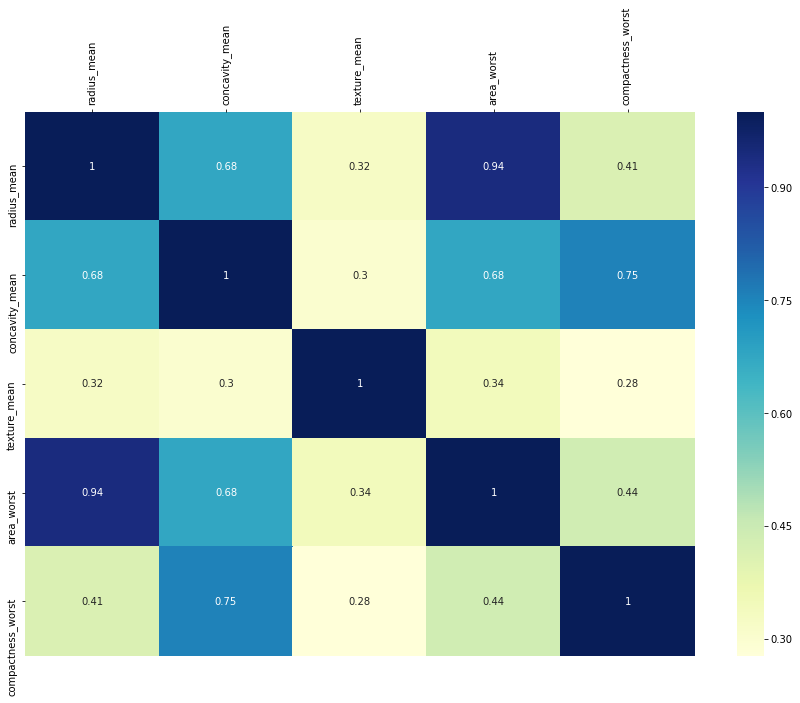

In [19]:
cont_list_f = ['radius_mean', 'concavity_mean', 'texture_mean', 'area_worst', 'compactness_worst']
plt.subplots(figsize=(15,10))
hm2 = sns.heatmap(df[cont_list_f].corr(), annot=True, cmap='YlGnBu')
hm2.set_xticklabels(hm2.get_xticklabels(), rotation=90)
hm2.xaxis.set_ticks_position('top')

By plotting the boxplots of each numerical column against the diagnosis type, we have picked out the significant features/predictors. More variation in the boxplot implies higher significance. We also eliminate features that are highly correlated. Therefore we can choose *radius_mean, radius_se, compactness_worst, concavity_mean, texture_mean* as the predictors for our model.

<a id='model'></a>
## 3. Create an XGBoost model

In this section, you will learn how to train and test an XGBoost model.

- [3.1 Split data](#prepare)
- [3.2 Create an XGBoost model](#create)

### 3.1 Split data<a id='prepare'></a>

You will pass the data with the selected significant predictors to build the model. You will use the `diagnosis` column as your target variable.

In [20]:
# Choosing the significant predictors.

X = df.iloc[:, [1,2,7,24,26]]
X = X.values

# Changing the target variables to binary variables
y = (df['diagnosis'] == 'M').astype(int)
y = y.values

Split the data set into: 
- Train data set
- Test data set

In [ ]:
!pip install scikit-learn==0.19.1

In [22]:
# Split the data set and create two data sets.
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=143)

In [23]:
# List the number of records in each data set.
print('Number of training records: ' + str(len(X_train)))
print('Number of testing records : ' + str(len(X_test)))

Number of training records: 369
Number of testing records : 200


The data has been successfully split into two data sets:
- The train data set which is the largest group will be used for training.
- The test data set will be used for model evaluation and is used to test the assumptions of the model.

### 3.2 Create an XGBoost model<a id='create'></a>

Install required packages.

**Tip:** Make sure `xgboost`'s version is 0.80.

In [24]:
!pip install 'xgboost==0.80'

In [25]:
import xgboost
xgboost.__version__

'0.80'

In [26]:
# Import packages you need to create the XGBoost model.
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#### 3.2.1 Create an XGBoost classifier

In this subsection, you will create an XGBoost classifier with default hyperparameters and you will call *xgb_model*. 

**Note**: The next sections show you how to improve this base model.

In [27]:
# Create the XGB classifier - xgb_model.
xgb_model = XGBClassifier(n_estimators=100)

Display the default parameters for *xgb_model*.

In [28]:
# List the default parameters.
print(xgb_model.get_xgb_params())

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 1}


Now, that your XGBoost classifier *xgb_model* is set up, you can train it by using the fit method. You will also evaluate *xgb_model* as the train and test data are being trained.

In [29]:
# Train and evaluate.
xgb_model.fit(X_train, y_train, eval_metric=['error'], eval_set=[((X_train, y_train)),(X_test, y_test)])

[0]	validation_0-error:0.0271	validation_1-error:0.07
[1]	validation_0-error:0.0271	validation_1-error:0.07
[2]	validation_0-error:0.0271	validation_1-error:0.07
[3]	validation_0-error:0.0271	validation_1-error:0.07
[4]	validation_0-error:0.0271	validation_1-error:0.07
[5]	validation_0-error:0.0271	validation_1-error:0.07
[6]	validation_0-error:0.0271	validation_1-error:0.07
[7]	validation_0-error:0.0271	validation_1-error:0.07
[8]	validation_0-error:0.0271	validation_1-error:0.07
[9]	validation_0-error:0.0271	validation_1-error:0.07
[10]	validation_0-error:0.0271	validation_1-error:0.07
[11]	validation_0-error:0.0271	validation_1-error:0.07
[12]	validation_0-error:0.0271	validation_1-error:0.06
[13]	validation_0-error:0.0271	validation_1-error:0.065
[14]	validation_0-error:0.0271	validation_1-error:0.055
[15]	validation_0-error:0.01897	validation_1-error:0.05
[16]	validation_0-error:0.01897	validation_1-error:0.05
[17]	validation_0-error:0.01897	validation_1-error:0.05
[18]	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Plot the model performance evaluated during the training process to assess model overfitting.

Text(0.5, 0, 'Number of iterations')

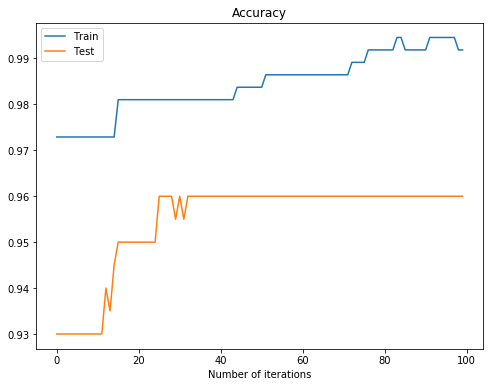

In [30]:
# Plot and display the performance evaluation
xgb_eval = xgb_model.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations')

You can see that there is model overfitting, and there is no increase in model accuracy after about 40 iterations.

Select the trained model obtained after 40 iterations.

In [31]:
# Select trained model.
n_trees = 40
y_pred = xgb_model.predict(X_test, ntree_limit= n_trees)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [32]:
# Check the accuracy of the trained model.
accuracy = accuracy_score(y_test, y_pred)

print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 96.00%


**Note:** You will use the test data accuracy to compare the accuracy of the model with *default* parameters to the accuracy of the model with *tuned* parameters.

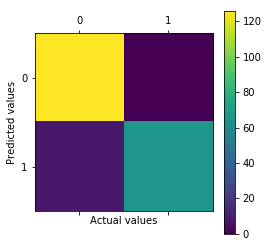

0   1
0  126   0
1    8  66

In [33]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm)
plt.colorbar()
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()
pd.DataFrame(cm)

This confusion matrix maps the predicted values against the actual values. Here, you can see that 126 benign tumors and 66 malignant tumors have been predicted correctly. However, 8 benign tumors have been incorrectly predicted as malignant. 

Text(0, 0.5, 'True Positive Rate')

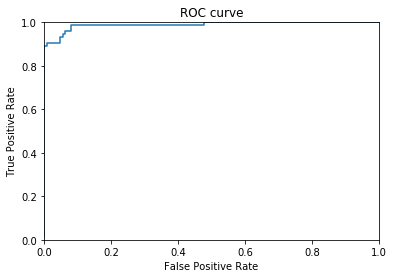

In [34]:
y_pred_prob = xgb_model.predict_proba(X_test)

# ROC-AUC curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

This is the ROC-AUC curve - the area under the curve represents the accuracy of the predictions. You can see that the area under the curve is large, indicating that the predictions are highly accurate.

#### 3.2.2 Use grid search and cross-validation to tune the model 

You can use grid search and cross-validation to tune your model to achieve better accuracy.

**Note**: Grid search is used for this model as an example, but it is **not** recommended for small data sets such as this one, as it might lead to overfitting.

XGBoost has an extensive catalog of hyperparameters which provides great flexibility to shape an algorithm’s desired behavior. Here you will the optimize the model tuning which adds an L1 penalty (`reg_alpha`).

Use a 5-fold cross-validation because your training data set is small.

In the cell below, create the XGBoost pipeline and set up the parameter grid for the grid search.

In [35]:
# Create XGBoost pipeline, set up parameter grid.
xgb_model_gs = XGBClassifier()
parameters = {'reg_alpha': [0.0, 1.0, 2.0], 'reg_lambda': [0.0, 1.0, 2.0], 'n_estimators': [n_trees], 'seed': [1337]}

Use ``GridSearchCV`` to search for the best parameters from the specified values in the previous cell.

In [36]:
# Search for the best parameters.
clf = GridSearchCV(estimator = xgb_model_gs, param_grid = parameters, scoring='accuracy', cv=5, verbose=1, n_jobs=1, refit=True)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty ar

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'reg_alpha': [0.0, 1.0, 2.0], 'reg_lambda': [0.0, 1.0, 2.0], 'n_estimators': [40], 'seed': [1337]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

You can see the cross validation results that were evaluated by the grid search.

In [37]:
# Print model cross validation results.
for key in ['params', 'mean_train_score', 'std_train_score', 'mean_test_score', 'std_test_score']:
    print(str(key) + ': \n' + str(clf.cv_results_[key]) + '\n\n')

params: 
[{'n_estimators': 40, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 1.0, 'reg_lambda': 0.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 2.0, 'reg_lambda': 0.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 2.0, 'reg_lambda': 1.0, 'seed': 1337}, {'n_estimators': 40, 'reg_alpha': 2.0, 'reg_lambda': 2.0, 'seed': 1337}]


mean_train_score: 
[0.9878034  0.98441125 0.98237964 0.98305761 0.98237964 0.98170397
 0.97967236 0.97628711 0.97628711]


std_train_score: 
[0.00460484 0.00553239 0.00335588 0.00431358 0.00335588 0.00347903
 0.00217    0.00302744 0.00302744]


mean_test_score: 
[0.95392954 0.95392954 0.95663957 0.95934959 0.95934959 0.95663957
 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


Display the accuracy estimated using cross-validation and the hyperparameter values for the best model.

In [38]:
print('Best score: %.1f%%' % (clf.best_score_*100))
print('Best parameter set: %s' % (clf.best_params_))

Best score: 95.9%
Best parameter set: {'n_estimators': 40, 'reg_alpha': 1.0, 'reg_lambda': 0.0, 'seed': 1337}


Display the accuracy of the best parameter combination on the test set.

In [39]:
y_pred = clf.best_estimator_.predict(X_test, ntree_limit= n_trees)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 95.50%


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The test set's accuracy is about the same for both the tuned model and the trained model with default hyperparameter values, even though the tuned hyperparameters are different from the default parameters.

#### 3.2.3 Model with pipeline data preprocessing

In this subsection, you will learn how to use the XGBoost model within the scikit-learn pipeline. 

Let's start by importing the required modules.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [41]:
pca = PCA(n_components=5)
xgb_model_pca = XGBClassifier(n_estimators=n_trees)
pipeline = Pipeline(steps=[('pca', pca), ('xgb', xgb_model_pca)])

In [42]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

Now, you are ready to evaluate the accuracy of the model trained on the reduced set of features.

In [43]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 95.00%


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


You can see that this model has an accuracy similar to the model trained using default hyperparameters.

Let's see how you can save the XGBoost pipeline using the WML service instance and deploy it for online scoring.

<a id='persistence'></a>
## 4. Persist the model

In this section, you will learn how to use the `watson-machine-learning-client` package to store your XGBoost model in the WML repository.

In [44]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [ ]:
!pip install --upgrade watson-machine-learning-client

In [46]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

Authenticate the Watson Machine Learning service on the IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-get-wml-credentials.html" target="_blank" rel="noopener no referrer">Service Credentials</a> tab of the service instance that you created on the IBM Cloud. <BR>If you cannot find the **instance_id** field in **Service Credentials**, click **New credential (+)** to generate new authentication information. 

**Action**: Enter your Watson Machine Learning service instance credentials here.

In [47]:
wml_credentials = {
    "apikey": "***",
    "instance_id": "***",
    "password": "***",
    "url": "https://ibm-watson-ml.mybluemix.net",
    "username": "***"
}

In [49]:
client = WatsonMachineLearningAPIClient(wml_credentials)

### 4.1 Save the XGBoost model in the WML Repository

Save the model artifact as *XGBoost model for breast cancer* to your WML instance.

In [50]:
model_props = {client.repository.ModelMetaNames.NAME: 'XGBoost model for breast cancer'}
model_details = client.repository.store_model(pipeline, model_props)

In [51]:
print(model_details)

{'metadata': {'guid': 'be9ee3e9-b82d-4761-8962-20457201e2dd', 'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/be9ee3e9-b82d-4761-8962-20457201e2dd', 'created_at': '2019-07-08T19:12:41.728Z', 'modified_at': '2019-07-08T19:12:41.779Z'}, 'entity': {'runtime_environment': 'python-3.6', 'learning_configuration_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/be9ee3e9-b82d-4761-8962-20457201e2dd/learning_configuration', 'name': 'XGBoost model for breast cancer', 'learning_iterations_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/be9ee3e9-b82d-4761-8962-20457201e2dd/learning_iterations', 'feedback_url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/b4b6c696-172c-4164-8049-c0b621dbf3c9/published_models/be9ee3e9-b82d-4761-8962-20457201e2dd/feedback', 'latest_version': {'url': 'https://us-south.ml.cl

Get the saved model metadata from WML.

# 5. Deploy and score in the WML repository <a id="scoring"></a>


In this section, you will learn how to create online scoring and score a new data record in the WML repository.

You can list all stored models using the  `list_models` method.

In [52]:
# Display a list of all the models.
client.repository.list_models()

------------------------------------  -------------------------------------------  ------------------------  -----------------
GUID                                  NAME                                         CREATED                   FRAMEWORK
be9ee3e9-b82d-4761-8962-20457201e2dd  XGBoost model for breast cancer              2019-07-08T19:12:41.728Z  scikit-learn-0.19
53b90fb3-0d12-4d66-96c8-b4e4cf96a0ae  Customer churn Spark model                   2019-07-03T15:47:49.776Z  mllib-2.3
ad24c140-f97a-49f2-b02c-f8ce44a58c27  Custom ARIMA estimator for sklearn pipeline  2019-07-03T01:04:33.998Z  scikit-learn-0.19
471b39cc-9c3b-4ff9-a8ea-0297efe0ca5d  Boston house price prediction                2019-05-20T18:19:55.433Z  scikit-learn-0.19
fc5462c8-7eb9-4dda-8b0a-947e2faa30da  WML Product Line Prediction Model            2019-05-17T17:33:53.278Z  mllib-2.3
a57e82a9-076e-4236-8bd2-7465e726c419  WML Product Line Prediction Model            2019-05-17T17:28:36.434Z  mllib-2.3
914b598b-f52e-4a

You need the model uid to create the deployment. You can extract the model uid from the saved model details.

In [53]:
# Extract the uid.
model_uid = client.repository.get_model_uid(model_details)
print(model_uid)

be9ee3e9-b82d-4761-8962-20457201e2dd


Use this modul_uid in the next section to create the deployment.

### 5.1 Create a model deployment

Now, you can create a deployment, *Predict breast cancer*.

In [54]:
# Create the deployment.
deployment_details = client.deployments.create(model_uid, 'Predict breast cancer')



#######################################################################################

Synchronous deployment creation for uid: 'be9ee3e9-b82d-4761-8962-20457201e2dd' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='3239e218-0fb9-4f62-9792-cc610c09ad65'
------------------------------------------------------------------------------------------------




Get the list of all deployments.

In [55]:
# List the deployments.
client.deployments.list()

------------------------------------  -------------------------------------------------------  -------  ------------------  ------------------------  -----------------  -------------
GUID                                  NAME                                                     TYPE     STATE               CREATED                   FRAMEWORK          ARTIFACT TYPE
3239e218-0fb9-4f62-9792-cc610c09ad65  Predict breast cancer                                    online   DEPLOY_SUCCESS      2019-07-08T19:12:44.101Z  scikit-learn-0.19  model
7985e484-4192-400e-82e5-3756d4600668  ARIMA model python function deployment                   online   DEPLOY_SUCCESS      2019-07-03T20:33:40.817Z  n/a                function
6aedb5b7-638a-4388-ab0d-45fecb3b7081  Customer Churn Prediction                                online   DEPLOY_SUCCESS      2019-07-03T15:51:34.166Z  mllib-2.3          model
cfcd5f9e-5b07-4bea-b57d-304c12254add  sklearn_pipeline_arima                                   online   DE

The *Predict breast cancer* model has been successfully deployed.

### 5.2 Perform prediction

Now, extract the url endpoint, *scoring_url*, which will be used to send scoring requests.

In [ ]:
# Extract endpoint url and display it.
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

Prepare the scoring payload with the values to score.

In [57]:
# Prepare scoring payload.
payload_scoring = {'values': [list(X_test[0]), list(X_test[1])]}
print(payload_scoring)

{'values': [[12.23, 19.56, 0.04187, 638.4, 0.2042], [16.27, 20.71, 0.1478, 1121.0, 0.2947]]}


In [58]:
# Perform prediction and display the result.
import json
response_scoring = client.deployments.score(scoring_url, payload_scoring)
print(json.dumps(response_scoring, indent=2))

{
  "fields": [
    "prediction",
    "probability"
  ],
  "values": [
    [
      0,
      [
        0.955904483795166,
        0.04409554600715637
      ]
    ],
    [
      1,
      [
        0.02002549171447754,
        0.9799745082855225
      ]
    ]
  ]
}


**Result**: The patient records are classified as a benign tumor and a malignant tumor respectively.

<a id='summary'></a>
## 6. Summary and next steps     

You have successfully completed this notebook! 

You learned how to use a machine learning algorithm called XGBoost as well as Watson Machine Learning to create and deploy a model. 

Check out our <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">Online Documentation</a> for more samples, tutorials, documentation, how-tos, and blog posts. 

### Citation

Lichman, M. (2013). <a href="http://archive.ics.uci.edu/ml" target="_blank" rel="noopener no referrer">UCI Machine Learning Repository</a>. Irvine, CA: University of California, School of Information and Computer Science.

### Authors

**Wojciech Sobala** is a Data Scientist at IBM.  
**Ananya Kaushik** is a Data Scientist at IBM.

Copyright © 2017-2019 IBM. This notebook and its source code are released under the terms of the MIT License.

<div style='background:#F5F7FA; height:110px; padding: 2em; font-size:14px;'>
<span style='font-size:18px;color:#152935;'>Love this notebook? </span>
<span style='font-size:15px;color:#152935;float:right;margin-right:40px;'>Don't have an account yet?</span><br>
<span style='color:#5A6872;'>Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style='border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;'><a href='https://ibm.co/wsnotebooks' target='_blank' style='color: #3d70b2;text-decoration: none;'>Sign Up</a></span><br>
</div>